In [3]:
## Define imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
import seaborn as sns
import os

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
consumption_df = pd.read_csv(f"historic_demand_2009_2023.csv", index_col=0)
consumption_df.head()

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,NaN,NaN,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,NaN,NaN,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,NaN,NaN,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,NaN,NaN,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,NaN,NaN,1


In [5]:
## Initial data exploration to see what we are deading with

### check the shape of the data
### check the total columns
print(consumption_df.shape)
print(consumption_df.columns)

(261456, 20)
Index(['settlement_date', 'settlement_period', 'nd', 'tsd',
       'england_wales_demand', 'embedded_wind_generation',
       'embedded_wind_capacity', 'embedded_solar_generation',
       'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping',
       'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow',
       'nemo_flow', 'nsl_flow', 'eleclink_flow', 'is_holiday'],
      dtype='object')


In [6]:
# @markdown The dataset is updated twice an hour providing us 48 entries for each day. From the printed columns above, we will keep the following columns to begin our analysis:
# @markdown 1. settlement_date
# @markdown 2. settlement_period
# @markdown 3. nd -> corresponds to national demand in MW. Sum of metered generation from UK household between 2009 - 2023. This will be our target variable which we aim to forecast ahead

In [7]:
## Filter the data to only include the columns we need
## Update the column names to be more readable
consumption_df = consumption_df[["settlement_date", "settlement_period", "nd"]]
consumption_df.columns = ["settlement_date", "settlement_period", "national_demand"]
consumption_df.head()

,settlement_date,settlement_period,national_demand
0,2009-01-01,1,37910
1,2009-01-01,2,38047
2,2009-01-01,3,37380
3,2009-01-01,4,36426
4,2009-01-01,5,35687


In [8]:
## We check for missing values
consumption_df.isnull().sum()

settlement_date      0
settlement_period    0
national_demand      0
dtype: int64

In [9]:
## Since no missing values, we can proceed to check if all settlement periods are present
## We expect 48 settlement periods per day
consumption_df.groupby("settlement_date").count()["settlement_period"].unique()

array([48, 46, 50])

In [10]:
## We see that some of the days have 46 recrods while some have 50 records
## lets find how many of these days are there

consumption_df.groupby("settlement_date").count()["settlement_period"].value_counts()

48    5417
46      15
50      15
Name: settlement_period, dtype: int64

In [11]:
## we see that there are 15 days with 46 records and 14 days with 50 records
## this seems substaniol enough to warrant further investigation.
## find the dates with 46 records and observe the data
for _, df in consumption_df.groupby("settlement_date"):
    if df.shape[0] == 46:
        print(df)

     settlement_date  settlement_period  national_demand
4176      2009-03-29                  1            32556
4177      2009-03-29                  2            32334
4178      2009-03-29                  3            31983
4179      2009-03-29                  4            31605
4180      2009-03-29                  5            31235
4181      2009-03-29                  6            30769
4182      2009-03-29                  7            29946
4183      2009-03-29                  8            29191
4184      2009-03-29                  9            28661
4185      2009-03-29                 10            28453
4186      2009-03-29                 11            28674
4187      2009-03-29                 12            28465
4188      2009-03-29                 13            28989
4189      2009-03-29                 14            29706
4190      2009-03-29                 15            30567
4191      2009-03-29                 16            31462
4192      2009-03-29           

In [12]:
## lets check the days with 50 records and observe the data
for _, df in consumption_df.groupby("settlement_date"):
    if df.shape[0] == 50:
        print(df)

      settlement_date  settlement_period  national_demand
14254      2009-10-25                  1            26115
14255      2009-10-25                  2            24948
14256      2009-10-25                  3            25518
14257      2009-10-25                  4            25647
14258      2009-10-25                  5            24972
14259      2009-10-25                  6            24308
14260      2009-10-25                  7            23652
14261      2009-10-25                  8            23370
14262      2009-10-25                  9            22860
14263      2009-10-25                 10            22397
14264      2009-10-25                 11            22159
14265      2009-10-25                 12            22154
14266      2009-10-25                 13            22336
14267      2009-10-25                 14            22744
14268      2009-10-25                 15            23820
14269      2009-10-25                 16            24325
14270      200

In [13]:
## for dates with 46 records, it seems like that the log for some hour was not recorded
## for dates with 50 records, it seems like that we had extra logs. there's no consecutive
## repition and since to time log is recorded, we can't tell which one is the correct one

## one pattern we see is there is a 2 day cycle of 46 and 50 records for each year
## hence, there shouldn't be much of an issue if we drop these days
## lets drop these days and check the shape of the data

## vicky: This is due to daylight saving time per year
## https://www.timeanddate.com/time/change/uk?year=2009

for _, df in consumption_df.groupby("settlement_date"):
    if df.shape[0] == 46 or df.shape[0] == 50:
        consumption_df.drop(df.index, inplace=True)
print(consumption_df.shape)

(260016, 3)


In [14]:
## check if the all the rows with 46 and 50 rows are removed
original_shape = 259774
new_shape = consumption_df.shape[0]

diff_rows = original_shape - new_shape


<Axes: xlabel='national_demand', ylabel='Count'>

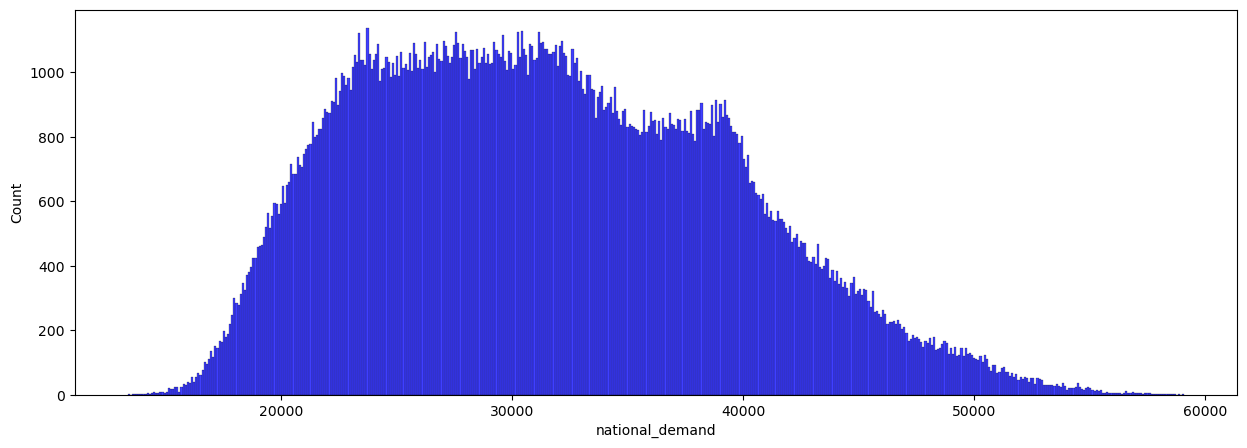

In [15]:
### lets have some preliminary visualizations to see how is the national demand distributed using a histogram
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=consumption_df, x="national_demand", bins=500, ax=ax, color="b")


In [16]:
# @markdown From the diagram above, it looks like that the overall distribution of national demand measured every 30 min is `positively skewed` as it has a heavier tail on the right side. Since the frequency of national demand is dense around the centre, it seems like a `platykurtic` distribution.

# @markdown We will calculate the skewness and kurtosis to confirm our intuition.

In [17]:
skewness = stats.skew(consumption_df["national_demand"].to_list(), bias=False)
skewness

0.3532607078961006

In [18]:
kurtosis = stats.kurtosis(consumption_df["national_demand"].to_list(), bias=False, fisher=False)
kurtosis

2.48312220086542

In [19]:
# @markdown Our intuition is correct.
# @markdown - The skewness is positive which means that the tail is on the right side of the distribution.
# @markdown - The kurtosis is less than 3 which means that the distribution is platykurtic. Also, this means that it does not produce many outliers which is good for our modelling purposes.

Text(0.5, 1.0, 'Distribution of electricity consumption with hours')

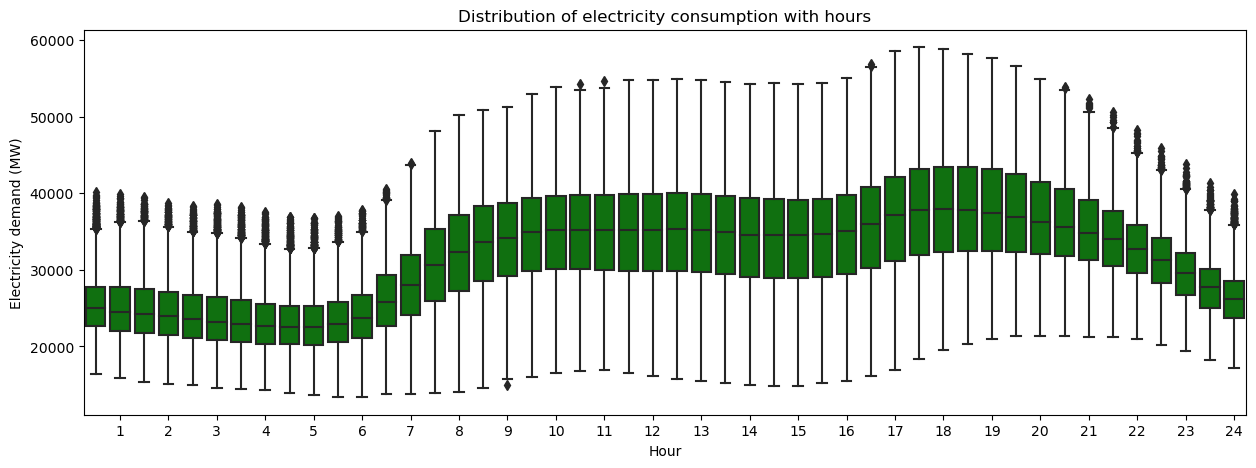

In [20]:
## for our analysis, we'll resample the data to a weekly basis
## however, we need to aggregate the data first on a daily basis and then resample it to a weekly basis.

## for this, lets create a box plot and see how the hourly demand is distributed
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=consumption_df, x="settlement_period", y="national_demand", ax=ax, color="g")

ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours")

In [21]:
# @markdown From here we see a pattern that hourly distribution shows higher electricity usage between 5pm - 8pm. Overall, hourly distribution seems to be fairly uniform with a few outliers. However, to not mask the affect of peak hours, we will use daily summed samples instead of mean

In [22]:
consumption_df["settlement_date"] = pd.to_datetime(consumption_df["settlement_date"])
grouped_consumption_df = consumption_df.groupby("settlement_date")

daily_summed_national_demand = grouped_consumption_df["national_demand"].sum().reset_index()
daily_summed_national_demand.columns = ["settlement_date", "daily_summed_national_demand"]
daily_summed_national_demand

,settlement_date,daily_summed_national_demand
0,2009-01-01,1789321
1,2009-01-02,1920721
2,2009-01-03,1897691
3,2009-01-04,1911407
4,2009-01-05,2181646
...,...,...
5412,2023-11-26,1478077
5413,2023-11-27,1566696
5414,2023-11-28,1594361
5415,2023-11-29,1663923


Text(0, 0.5, 'Daily Summed Electricity demand (MW)')

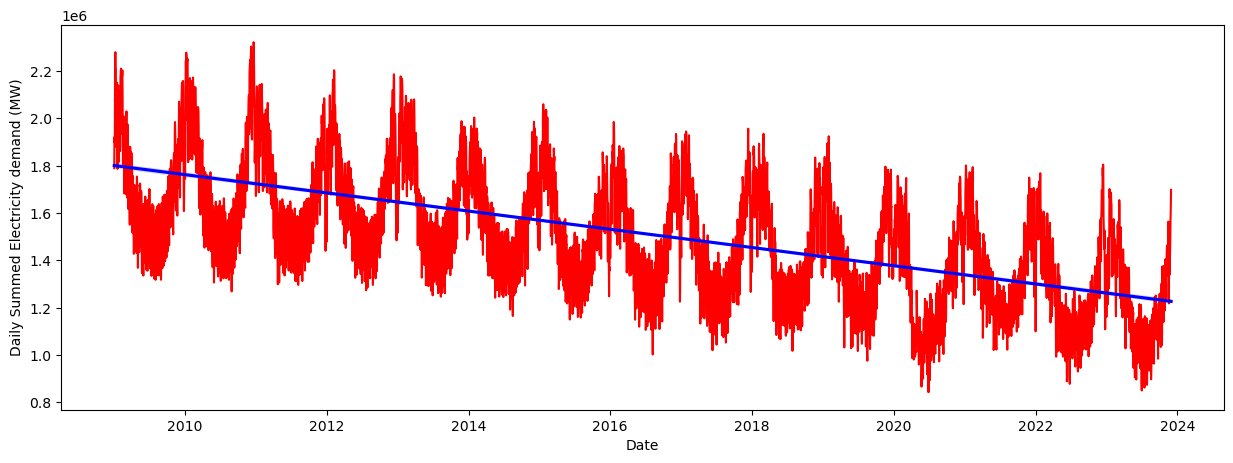

In [23]:
### lets plot our daily mean data to see how it looks
daily_summed_national_demand['numeric_date'] = mdates.date2num(daily_summed_national_demand['settlement_date'])

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=daily_summed_national_demand, x="settlement_date", y="daily_summed_national_demand", ax=ax, color="r")

sns.regplot(data=daily_summed_national_demand, x="numeric_date", y="daily_summed_national_demand",
            ax=ax, color="b", scatter=False)

ax.set_xlabel("Date")
ax.set_ylabel("Daily Summed Electricity demand (MW)")

In [24]:
# @markdown Interestingly, the daily naitonal demand is following a decreasing pattern. Even though, the population is increasing, this could be due to the fact that people are becoming more aware of the environmental issues and trying to reduce their carbon footprint.

# @markdown From the plot above, we can see that the national demand is following a seasonal pattern. The demand is higher during winter months and lower during summer months. This is due to the fact that people use more electricity to heat their houses during winter months.

In [25]:
## In our forecsat, it would ge good to capture the seasonality of the data
## Hence, we can resample the data to a weekly basis and then plot it to see how it looks

# drop numeric date column. we dont need it after line graph
daily_summed_national_demand = daily_summed_national_demand.drop("numeric_date", axis=1)

weekly_summed_national_demand = daily_summed_national_demand.resample("W", on="settlement_date").sum().reset_index()
weekly_summed_national_demand.columns = ["settlement_date", "weekly_summed_national_demand"]
weekly_summed_national_demand

,settlement_date,weekly_summed_national_demand
0,2009-01-04,7519140
1,2009-01-11,15046759
2,2009-01-18,14080079
3,2009-01-25,14237170
4,2009-02-01,14246472
...,...,...
774,2023-11-05,9395589
775,2023-11-12,9851889
776,2023-11-19,9733451
777,2023-11-26,9996301


/var/folders/w0/ngt_rfx56hl7qv31gndsdw3w0000gn/T/ipykernel_13567/3848400158.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_summed_national_demand['numeric_date'] = mdates.date2num(weekly_summed_national_demand['settlement_date'])


Text(0, 0.5, 'Weekly Summed Electricity demand (MW)')

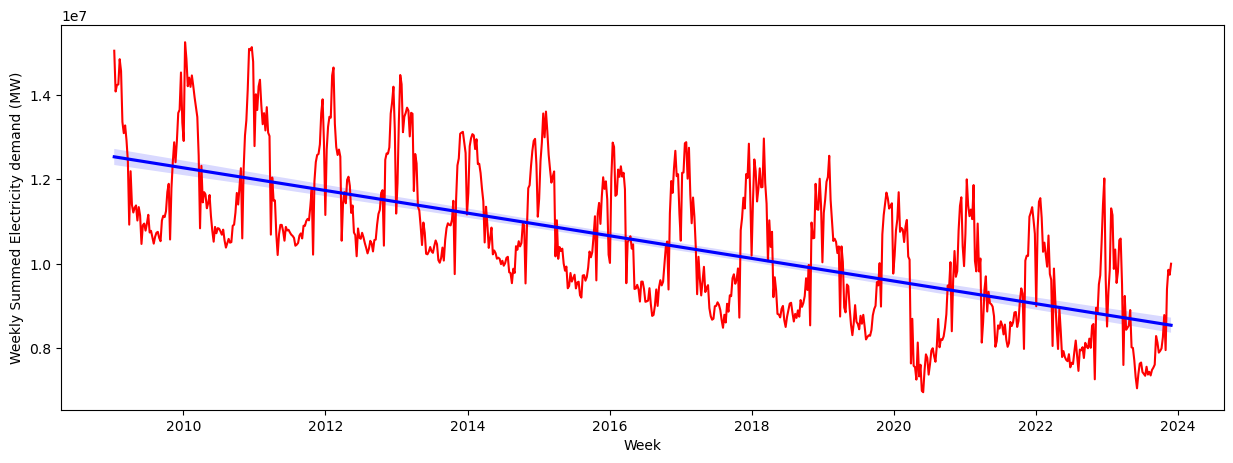

In [26]:
## we can drop the first and last week since they are incomplete
weekly_summed_national_demand = weekly_summed_national_demand[1:-1]

## lets plot our weekly mean data to see how it looks
weekly_summed_national_demand['numeric_date'] = mdates.date2num(weekly_summed_national_demand['settlement_date'])

fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data=weekly_summed_national_demand, x="settlement_date", y="weekly_summed_national_demand", ax=ax, color="r")

sns.regplot(data=weekly_summed_national_demand, x="numeric_date", y="weekly_summed_national_demand",
            ax=ax, color="b", scatter=False)

ax.set_xlabel("Week")
ax.set_ylabel("Weekly Summed Electricity demand (MW)")

/var/folders/w0/ngt_rfx56hl7qv31gndsdw3w0000gn/T/ipykernel_13567/3405422108.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['settlement_date'], dtype='object')
  rolling_mean = daily_summed_national_demand.rolling(window=4).mean()


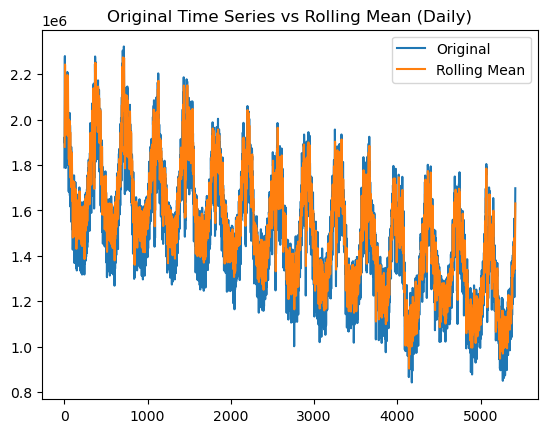

In [27]:
# Daily
rolling_mean = daily_summed_national_demand.rolling(window=4).mean()
plt.plot(daily_summed_national_demand["daily_summed_national_demand"], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.title('Original Time Series vs Rolling Mean (Daily)')
plt.legend()
plt.show()

/var/folders/w0/ngt_rfx56hl7qv31gndsdw3w0000gn/T/ipykernel_13567/3711190940.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['settlement_date'], dtype='object')
  rolling_var = daily_summed_national_demand.rolling(window=4).var()


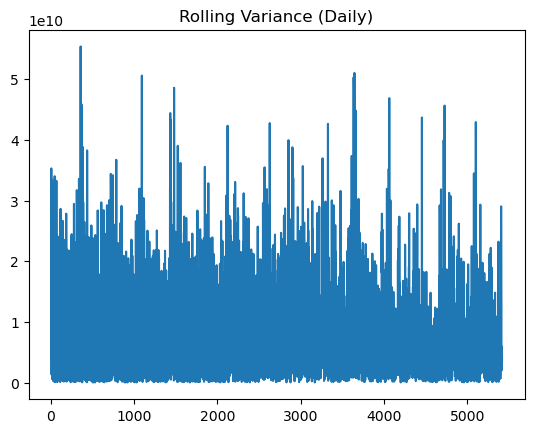

In [28]:
rolling_var = daily_summed_national_demand.rolling(window=4).var()
plt.plot(rolling_var)
plt.title('Rolling Variance (Daily)')
plt.show()

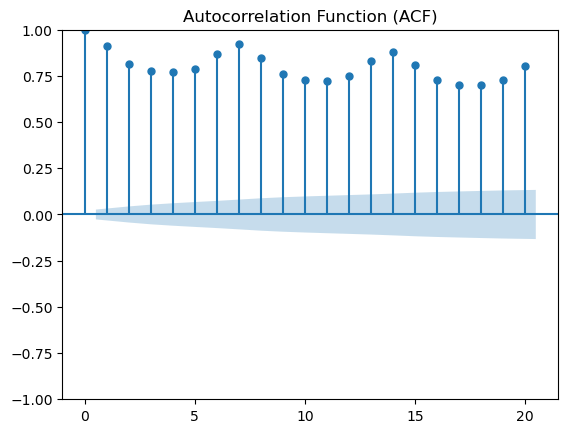

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(daily_summed_national_demand["daily_summed_national_demand"], lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()

/var/folders/w0/ngt_rfx56hl7qv31gndsdw3w0000gn/T/ipykernel_13567/280860648.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['settlement_date'], dtype='object')
  rolling_mean_weekly = weekly_summed_national_demand.rolling(window=4).mean()


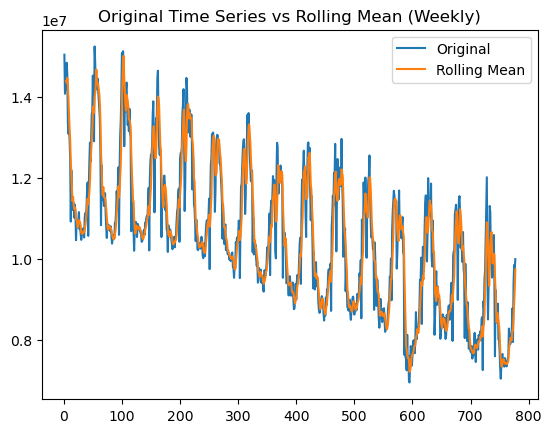

In [30]:
# Weekly
rolling_mean_weekly = weekly_summed_national_demand.rolling(window=4).mean()
plt.plot(weekly_summed_national_demand["weekly_summed_national_demand"], label='Original')
plt.plot(rolling_mean_weekly["weekly_summed_national_demand"], label='Rolling Mean')
plt.title('Original Time Series vs Rolling Mean (Weekly)')
plt.legend()
plt.show()

/var/folders/w0/ngt_rfx56hl7qv31gndsdw3w0000gn/T/ipykernel_13567/460550312.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['settlement_date'], dtype='object')
  rolling_var_weekly = weekly_summed_national_demand.rolling(window=4).var()


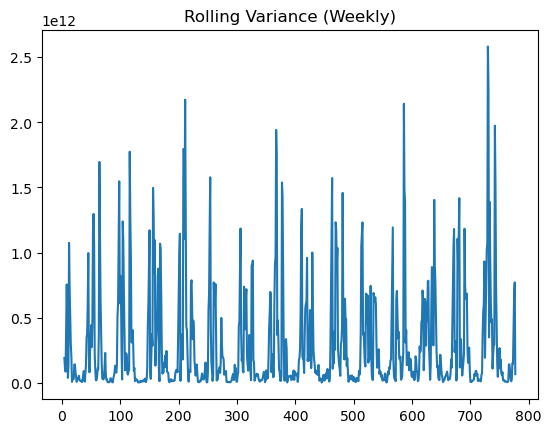

In [31]:
rolling_var_weekly = weekly_summed_national_demand.rolling(window=4).var()
plt.plot(rolling_var_weekly["weekly_summed_national_demand"])
plt.title('Rolling Variance (Weekly)')
plt.show()

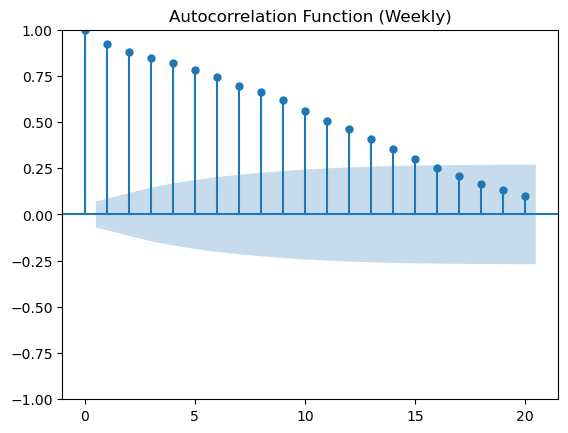

In [32]:
plot_acf(weekly_summed_national_demand["weekly_summed_national_demand"], lags=20)
plt.title('Autocorrelation Function (Weekly)')
plt.show()

From the above ACF figure, it is decaying, very slowly, and remains well above the significance range. This is indicative of a non-stationary series.Thus, it is certain that the time seris is not stationary.

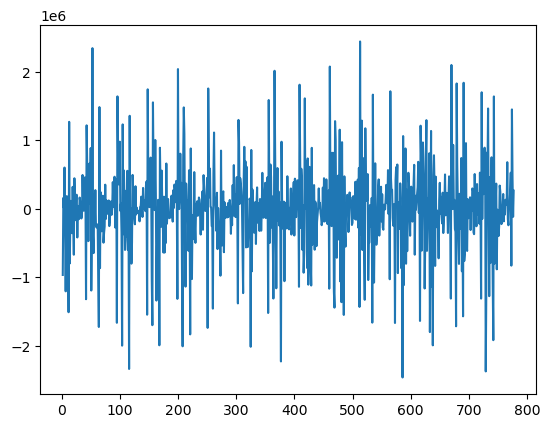

In [33]:
# Apply differencing and check if the data is stationary
weekly_summed_national_demand_diff = weekly_summed_national_demand.diff().dropna()
plt.plot(weekly_summed_national_demand_diff["weekly_summed_national_demand"])
plt.show()

From the looks of it, the mean looks stationary. We can confirm our hypothesis with an AD Fuller test. We will also plot the ACF and PACF to see if there is any trend or seasonality in our data.

In [34]:
# Perform ADF test
result = adfuller(weekly_summed_national_demand_diff["weekly_summed_national_demand"])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')

for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Since the p-value is less than 0.05, we can reject the null hypothesis and say that the series is stationary. We will now plot the ACF and PACF of differenced series to decide the value of p and q.

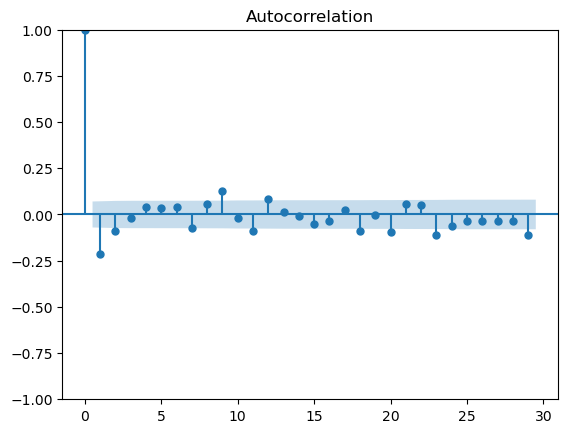

In [35]:
plot_acf(weekly_summed_national_demand_diff["weekly_summed_national_demand"])
plt.show()

From the ACF plot above, we can determine the value of p is 2 first.

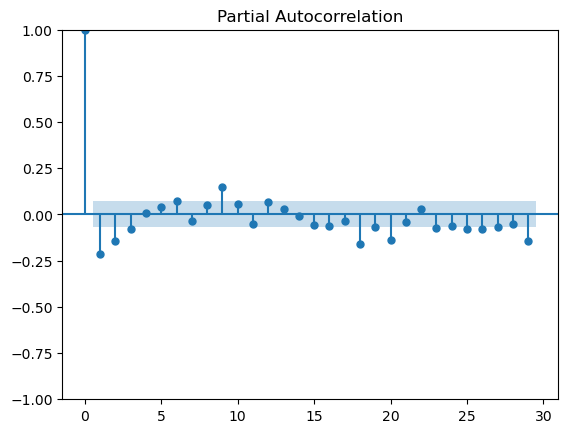

In [36]:
plot_pacf(weekly_summed_national_demand_diff["weekly_summed_national_demand"])
plt.show()

From the PACF plot above, we can determine the value of q is 3.

After that, we need to determine the seasonality of the model by decompose the timeseries model.

Therefore, we can first assume the time series model as ARIMA(2, 1, 3) and fit these parameters to the model and do the forecasting, after that we would do the diagnostics checking of the model and use AIC to choose the best ARIMA model later on to verify our assumption.

In [37]:
weekly_df = weekly_summed_national_demand[['settlement_date', 'weekly_summed_national_demand']]
weekly_df.set_index('settlement_date', inplace=True)
weekly_df

,weekly_summed_national_demand
settlement_date,
2009-01-11,15046759
2009-01-18,14080079
2009-01-25,14237170
2009-02-01,14246472
2009-02-08,14846340
...,...
2023-10-29,7947981
2023-11-05,9395589
2023-11-12,9851889


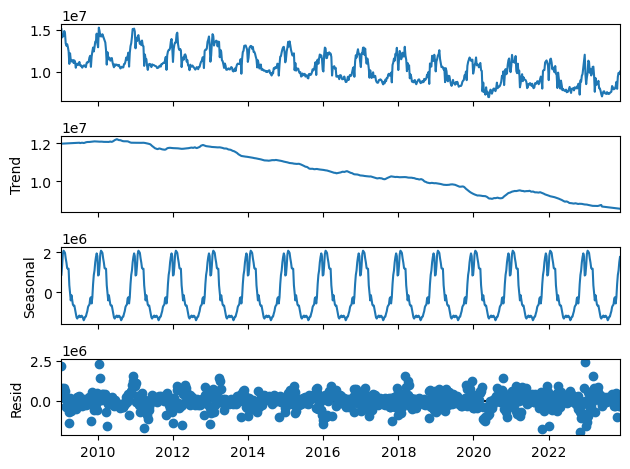

In [38]:
weekly_season = seasonal_decompose(weekly_df, model='additive',extrapolate_trend='freq')
weekly_season.plot()
plt.show()

In [39]:
# Perform ADF test for seasonal model
result_seasonal = adfuller(weekly_season.seasonal)
print(f'ADF Statistic: {result_seasonal[0]}')
print(f'p-value: {result_seasonal[1]}')
print('Critical Values:')

for key, value in result_seasonal[4].items():
  print('\t%s: %.3f' % (key, value))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


From the Adfuller Test, p-value is less than 0.05 so we can tell that the seasonal model of time series is stationary so D = 0 and no further differencing need to do within the time series.

Next step we are going to get the value of P and Q which follow the same step in above to plot the ACF and PACF of the time series model but this time we fit with the seasonal model.

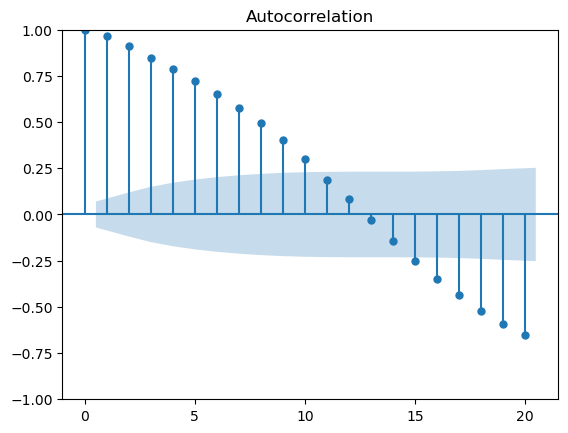

In [40]:
plot_acf(weekly_season.seasonal, lags = 20)
plt.show()

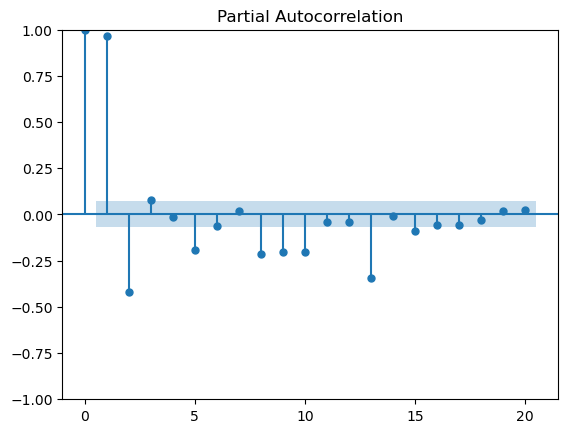

In [41]:
plot_pacf(weekly_season.seasonal, lags = 20)
plt.show()

From the above result, we can conclude that P = 3, D = 0, Q = 10. Since we can see that it has seasonal cycle per year, so we can decide S = 52 as we are using the weekly data, and there are 52 weeks per year.

Therefore our model will be SARIMA(2,1,3)x(3,0,10)52.

(a)	estimate the parameters.

(b)	use Ljung-Box test to check the fitted model is adequate or not. Please try several different K here.

(c)	use over-parameterized method to check the adequacy of the fitted model.

(d)	suggestion some alternative models if the fitted model is not adequate.

(e)	check these alternative models.



In [42]:
import pmdarima as pmdarima
from pmdarima.arima.utils import ndiffs
from pmdarima.arima.utils import nsdiffs

In [43]:
# Estimate the number of differences using an ADF test:
n_adf = ndiffs(weekly_summed_national_demand["weekly_summed_national_demand"], test='adf')  # -> 0

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [52]:
n_adf

0

In [40]:
# fit the model
model_seasonal = SARIMAX(weekly_df, order=(2, 1, 3), seasonal_order=(3, 0, 10, 52))

/Users/vicky/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/vicky/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [ ]:
#model_seasonal.fit()

In [41]:
weekly_df.shape

(777, 1)

In [42]:
weekly_df.head

<bound method NDFrame.head of                  weekly_summed_national_demand
settlement_date                               
2009-01-11                            15046759
2009-01-18                            14080079
2009-01-25                            14237170
2009-02-01                            14246472
2009-02-08                            14846340
...                                        ...
2023-10-29                             7947981
2023-11-05                             9395589
2023-11-12                             9851889
2023-11-19                             9733451
2023-11-26                             9996301

[777 rows x 1 columns]>

In [43]:
weekly_df_train = weekly_df[:416]

In [44]:
weekly_df_train.shape

(416, 1)

In [45]:
weekly_df_train.head

<bound method NDFrame.head of                  weekly_summed_national_demand
settlement_date                               
2009-01-11                            15046759
2009-01-18                            14080079
2009-01-25                            14237170
2009-02-01                            14246472
2009-02-08                            14846340
...                                        ...
2016-11-27                            12257535
2016-12-04                            12673977
2016-12-11                            12071828
2016-12-18                            12118779
2016-12-25                            11185121

[416 rows x 1 columns]>

In [46]:
# fit the model
model_seasonal = SARIMAX(weekly_df_train, order=(2, 1, 3), seasonal_order=(3, 0, 10, 52), simple_differencing=True)

/Users/vicky/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/vicky/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [ ]:
model_seasonal.fit()

/Users/vicky/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### XGBoost

In [103]:
weekly_summed_national_demand_feature = weekly_summed_national_demand.copy()

In [104]:
weekly_summed_national_demand_feature.dtypes

settlement_date                  datetime64[ns]
weekly_summed_national_demand             int64
numeric_date                            float64
dtype: object

In [105]:
weekly_summed_national_demand_feature.head()

,settlement_date,weekly_summed_national_demand,numeric_date
1,2009-01-11,15046759,14255.0
2,2009-01-18,14080079,14262.0
3,2009-01-25,14237170,14269.0
4,2009-02-01,14246472,14276.0
5,2009-02-08,14846340,14283.0


In [106]:
weekly_summed_national_demand_feature["quarter"] = weekly_summed_national_demand_feature['settlement_date'].dt.quarter.astype(int)
weekly_summed_national_demand_feature["month"] = weekly_summed_national_demand_feature['settlement_date'].dt.month.astype(int)
weekly_summed_national_demand_feature["year"] = weekly_summed_national_demand_feature['settlement_date'].dt.year.astype(int)
weekly_summed_national_demand_feature["week_of_year"] =  weekly_summed_national_demand_feature['settlement_date'].dt.isocalendar().week.astype(int)

In [107]:
weekly_summed_national_demand_feature.tail()

,settlement_date,weekly_summed_national_demand,numeric_date,quarter,month,year,week_of_year
773,2023-10-29,7947981,19659.0,4,10,2023,43
774,2023-11-05,9395589,19666.0,4,11,2023,44
775,2023-11-12,9851889,19673.0,4,11,2023,45
776,2023-11-19,9733451,19680.0,4,11,2023,46
777,2023-11-26,9996301,19687.0,4,11,2023,47


In [108]:
print(weekly_summed_national_demand_feature.iloc[776].index)

Index(['settlement_date', 'weekly_summed_national_demand', 'numeric_date',
       'quarter', 'month', 'year', 'week_of_year'],
      dtype='object')


### add 3 years lag to the dataset

In [109]:
weekly_summed_national_demand_feature.set_index("settlement_date", inplace=True)

In [110]:
target_map = weekly_summed_national_demand_feature["weekly_summed_national_demand"].to_dict()

In [111]:
weekly_summed_national_demand_feature["lag1"] = (weekly_summed_national_demand_feature.index - pd.Timedelta(weeks=52)).map(target_map)

In [112]:
weekly_summed_national_demand_feature["lag2"] = (weekly_summed_national_demand_feature.index - pd.Timedelta(weeks=104)).map(target_map)

In [113]:
weekly_summed_national_demand_feature["lag3"] = (weekly_summed_national_demand_feature.index - pd.Timedelta(weeks=156)).map(target_map)

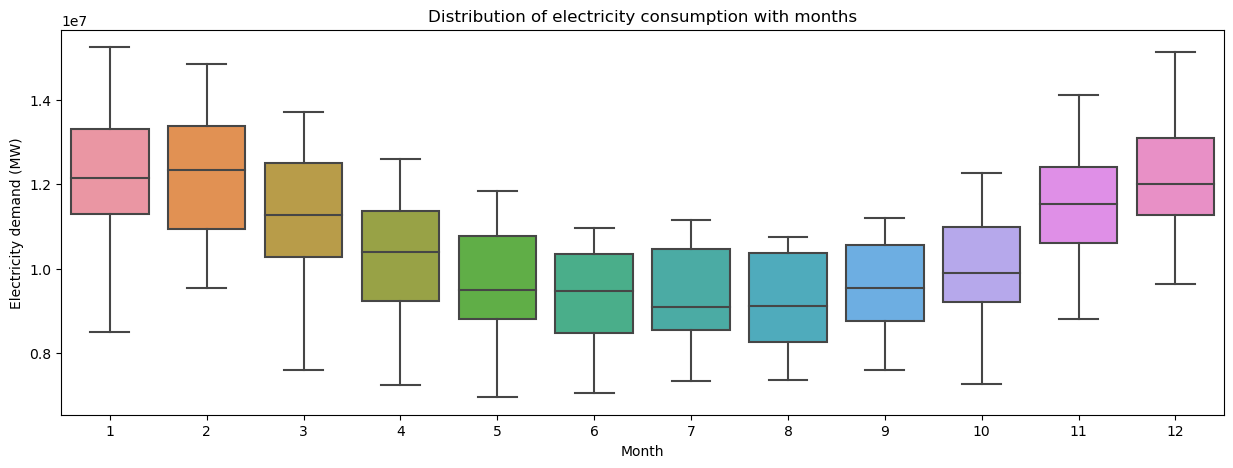

In [114]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="weekly_summed_national_demand", data=weekly_summed_national_demand_feature)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months");

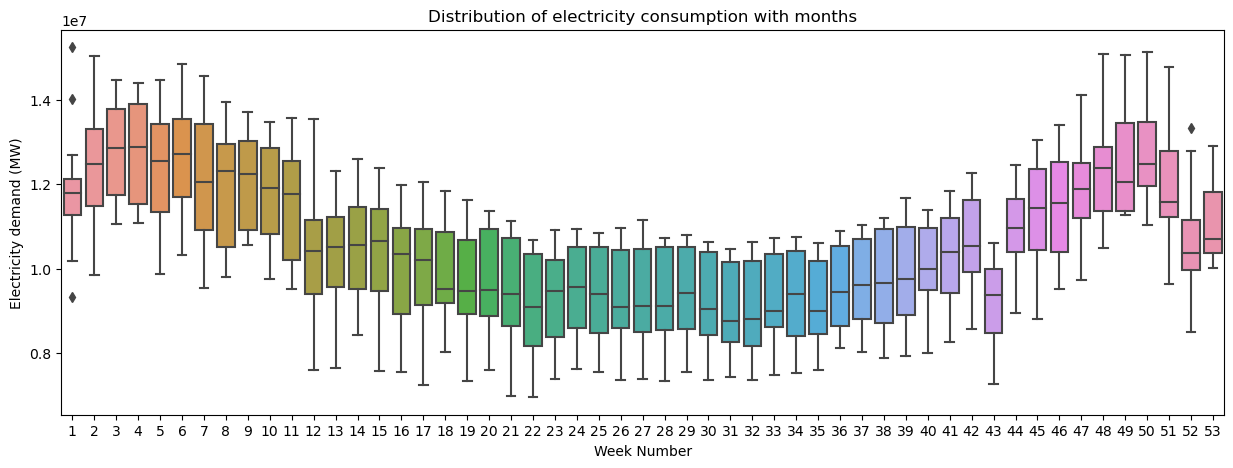

In [115]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="week_of_year", y="weekly_summed_national_demand", data=weekly_summed_national_demand_feature)

ax.set_xlabel("Week Number")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months");

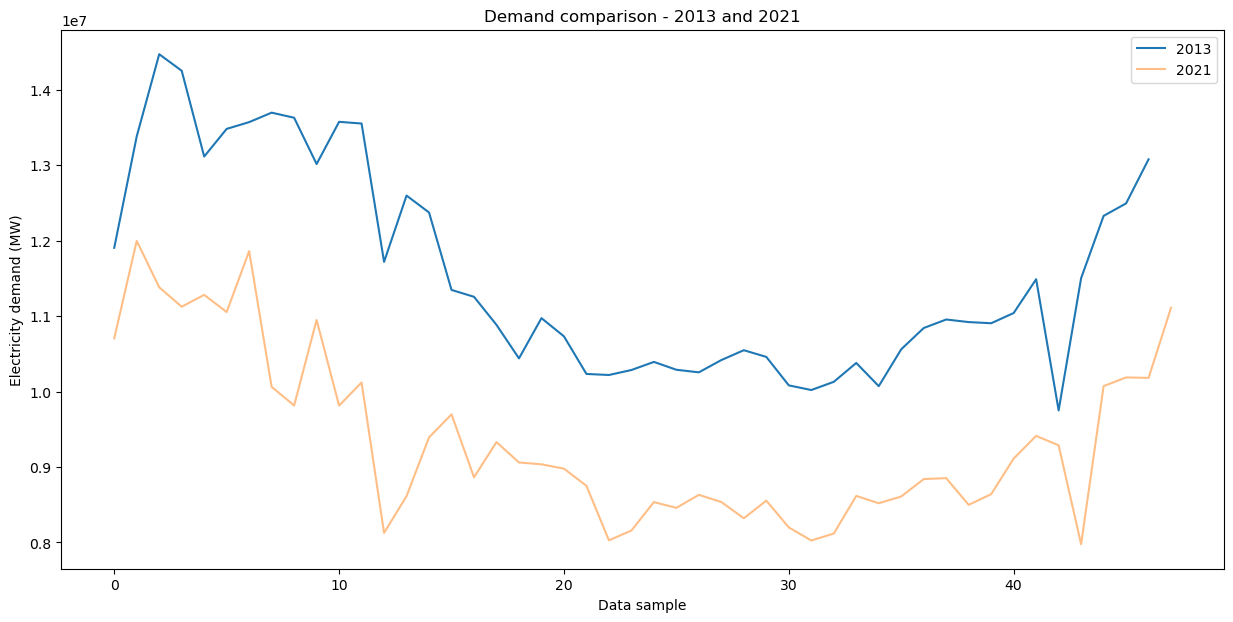

In [116]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(weekly_summed_national_demand_feature.loc[(weekly_summed_national_demand_feature.index > "01-01-2013") & (weekly_summed_national_demand_feature.index < "12-01-2013")]["weekly_summed_national_demand"])),
    weekly_summed_national_demand_feature.loc[(weekly_summed_national_demand_feature.index > "01-01-2013") & (weekly_summed_national_demand_feature.index < "12-01-2013")]["weekly_summed_national_demand"],
    label="2013",
)

ax.plot(
    range(len(weekly_summed_national_demand_feature.loc[(weekly_summed_national_demand_feature.index > "01-01-2021") & (weekly_summed_national_demand_feature.index < "12-01-2021")]["weekly_summed_national_demand"])),
    weekly_summed_national_demand_feature.loc[(weekly_summed_national_demand_feature.index > "01-01-2021") & (weekly_summed_national_demand_feature.index < "12-01-2021")]["weekly_summed_national_demand"],
    alpha=0.5,
    label="2021",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021");

In [117]:
threshold_date_1 = "01-01-2019"
threshold_date_2 = "01-01-2021"
train_data = weekly_summed_national_demand_feature.loc[weekly_summed_national_demand_feature.index < threshold_date_1]
test_data = weekly_summed_national_demand_feature.loc[(weekly_summed_national_demand_feature.index >= threshold_date_1) & (weekly_summed_national_demand_feature.index < threshold_date_2)]
hold_out_data = weekly_summed_national_demand_feature.loc[weekly_summed_national_demand_feature.index >= threshold_date_2]

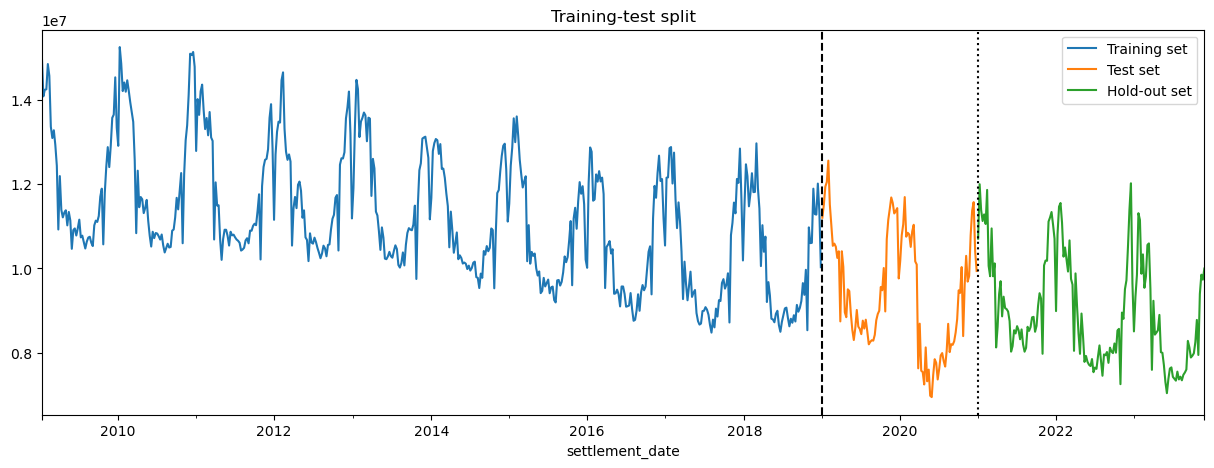

In [118]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["weekly_summed_national_demand"].plot(ax=ax, label="Training set")
test_data["weekly_summed_national_demand"].plot(ax=ax, label="Test set")
hold_out_data["weekly_summed_national_demand"].plot(ax=ax, label="Hold-out set")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Training-test split")
plt.legend();

In [119]:
train_data

,weekly_summed_national_demand,numeric_date,quarter,month,year,week_of_year,lag1,lag2,lag3
settlement_date,,,,,,,,,
2009-01-11,15046759,14255.0,1,1,2009,2,NaN,NaN,NaN
2009-01-18,14080079,14262.0,1,1,2009,3,NaN,NaN,NaN
2009-01-25,14237170,14269.0,1,1,2009,4,NaN,NaN,NaN
2009-02-01,14246472,14276.0,1,2,2009,5,NaN,NaN,NaN
2009-02-08,14846340,14283.0,1,2,2009,6,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2018-12-02,11288344,17867.0,4,12,2018,48,12121936.0,12673977.0,11771165.0
2018-12-09,11275557,17874.0,4,12,2018,49,12027974.0,12071828.0,11949368.0
2018-12-16,12011482,17881.0,4,12,2018,50,12842243.0,12118779.0,11520834.0


In [89]:
train_data = train_data.reset_index()
test_data = test_data.reset_index()
hold_out_data = hold_out_data.reset_index()

In [90]:
train_data.columns

Index(['settlement_date', 'weekly_summed_national_demand', 'numeric_date',
       'quarter', 'month', 'year', 'week_of_year', 'lag1', 'lag2', 'lag3'],
      dtype='object')

In [120]:
# Define the features and target variable
FEATURES = [
    "numeric_date",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "weekly_summed_national_demand"

# Prepare the training, testing and hold-out data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES]
y_hold_out = hold_out_data[TARGET]


In [121]:
X_train.dtypes

numeric_date    float64
quarter           int64
month             int64
year              int64
week_of_year      int64
dtype: object

In [ ]:
# Initialize and fit the XGBoost model
import xgboost as xgb
xgb_simple = xgb.XGBRegressor(
    n_estimators=500, 
    max_depth=3, 
    learning_rate=0.01, 
    early_stopping_rounds=50, 
#     tree_method="gpu_hist",
    random_state=43, 
    enable_categorical = True
)

xgb_simple.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_hold_out, y_hold_out)],
    verbose=100
);